## pix2pix(U-Net + GAN) experiments

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tnrange, tqdm_notebook

### Model definitions

In [2]:
from keras import objectives
from keras import backend as K
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Activation, Dropout
from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
# U-Net Generator
def g_unet(nf, a_ch=1, b_ch=1, out_ch=1, batch_size=1, alpha=0.2, model_name='unet'):
    ''' параметры:
    input shape = (256, 256, a_ch + b_ch)
    output = (256, 256, out_ch)
    nf - число фильтров на входном слое
    alpha - параметр LeakyReLU
    '''
    i = Input(shape=(256, 256, a_ch + b_ch))
    # (256, 256, a_ch + b_ch)
    
    conv1 = Conv2D(nf, (3, 3), padding='same', strides=(2, 2))(i)
    conv1 = BatchNormalization(axis=3)(conv1)
    x = LeakyReLU(alpha)(conv1)
    # (128, 128, nf)
    
    conv2 = Conv2D(nf*2, (3, 3), padding='same', strides=(2, 2))(x)
    conv2 = BatchNormalization(axis=3)(conv2)
    x = LeakyReLU(alpha)(conv2)
    # (64, 64, nf*2)
    
    conv3 = Conv2D(nf*4, (3, 3), padding='same', strides=(2, 2))(x)
    conv3 = BatchNormalization(axis=3)(conv3)
    x = LeakyReLU(alpha)(conv3)
    # (32, 32, nf*4)

    conv4 = Conv2D(nf*8, (3, 3), padding='same', strides=(2, 2))(x)
    conv4 = BatchNormalization(axis=3)(conv4)
    x = LeakyReLU(alpha)(conv4)
    # (16, 16, nf*8)
    
    conv5 = Conv2D(nf*8, (3, 3), padding='same', strides=(2, 2))(x)
    conv5 = BatchNormalization(axis=3)(conv5)
    x = LeakyReLU(alpha)(conv5)
    # (8, 8, nf*8)
    
    conv6 = Conv2D(nf*8, (3, 3), padding='same', strides=(2, 2))(x)
    conv6 = BatchNormalization(axis=3)(conv6)
    x = LeakyReLU(alpha)(conv6)
    # (4, 4, nf*8)
    
    conv7 = Conv2D(nf*8, (3, 3), padding='same', strides=(2, 2))(x)
    conv7 = BatchNormalization(axis=3)(conv7)
    x = LeakyReLU(alpha)(conv7)
    # (2, 2, nf*8)
    
    conv8 = Conv2D(nf*8, (2, 2), padding='valid', strides=(1, 1))(x)
    conv8 = BatchNormalization(axis=3)(conv8)
    x = LeakyReLU(alpha)(conv8)
    # (1, 1, nf*8)

    dconv1 = Conv2DTranspose(nf*8, (2, 2), strides=(1, 1))(x)
    dconv1 = BatchNormalization(axis=3)(dconv1)
    dconv1 = Dropout(0.5)(dconv1)
    #x = concatenate([dconv1, conv7], axis=3)
    x = dconv1
    x = LeakyReLU(alpha)(x)
    # (2, 2, nf*(8 + 8))

    dconv2 = Conv2DTranspose(nf*8, (2, 2), strides=(2, 2))(x)
    dconv2 = BatchNormalization(axis=3)(dconv2)
    dconv2 = Dropout(0.5)(dconv2)
    #x = concatenate([dconv2, conv6], axis=3)
    x = dconv2
    x = LeakyReLU(alpha)(x)
    # (4, 4, nf*(8 + 8))

    dconv3 = Conv2DTranspose(nf*8, (2, 2), strides=(2, 2))(x)
    dconv3 = BatchNormalization(axis=3)(dconv3)
    #x = concatenate([dconv3, conv5], axis=3)
    x = dconv3
    x = LeakyReLU(alpha)(x)
    # (8, 8, nf*(8 + 8))
    
    dconv4 = Conv2DTranspose(nf*8, (2, 2), strides=(2, 2))(x)
    dconv4 = BatchNormalization(axis=3)(dconv4)
    #x = concatenate([dconv4, conv4], axis=3)
    x = dconv4
    x = LeakyReLU(alpha)(x)
    # (16, 16, nf*(8 + 8))
    
    dconv5 = Conv2DTranspose(nf*4, (2, 2), strides=(2, 2))(x)
    dconv5 = BatchNormalization(axis=3)(dconv5)
    #x = concatenate([dconv5, conv3], axis=3)
    x = dconv5
    x = LeakyReLU(alpha)(x)
    # (32, 32, nf*(4 + 4))
    
    dconv6 = Conv2DTranspose(nf*2, (2, 2), strides=(2, 2))(x)
    dconv6 = BatchNormalization(axis=3)(dconv6)
    #x = concatenate([dconv6, conv2], axis=3)
    x = dconv6
    x = LeakyReLU(alpha)(x)
    # (64, 64, nf*(2 + 2))
    
    dconv7 = Conv2DTranspose(nf, (2, 2), strides=(2, 2))(x)
    dconv7 = BatchNormalization(axis=3)(dconv7)
    #x = concatenate([dconv7, conv1], axis=3)
    x = dconv7
    x = LeakyReLU(alpha)(x)
    # (128, 128, nf*(1 + 1))

    dconv8 = Conv2DTranspose(out_ch, (2, 2), strides=(2, 2))(x)
    # (256, 256, out_ch)
    

    out = Activation('tanh')(dconv8)
    unet = Model(i, out, name=model_name)
    
    return unet

In [4]:
# Discriminator
def discriminator(nf, a_ch=1, b_ch=1, c_ch=1, opt=Adam(lr=2e-4, beta_1=0.5), alpha=0.2, model_name='d'):
    ''' параметры:
    a_ch - число каналов первого изображения
    b_ch - число каналов второго
    c_ch - третьего
    nf - число фильтров на входном слое
    alpha - параметр LeakyReLU
    '''
    i = Input(shape=(256, 256, a_ch + b_ch + c_ch))
    # (256, 256, a_ch + b_ch + c_ch)
    
    conv1 = Conv2D(nf, (3, 3), padding='same', strides=(2,2))(i)
    x = LeakyReLU(alpha)(conv1)
    # (128, 128, nf)
    
    conv2 = Conv2D(nf*2, (3, 3), padding='same', strides=(2,2))(x)
    x = LeakyReLU(alpha)(conv2)
    # (64, 64, nf*2)
    
    conv3 = Conv2D(nf*4, (3, 3), padding='same', strides=(2,2))(x)
    x = LeakyReLU(alpha)(conv3)
    # (32, 32, nf*4)
    
    conv4 = Conv2D(nf*8, (3, 3), padding='same', strides=(2,2))(x)
    x = LeakyReLU(alpha)(conv4)
    # (16, 16, nf*8)
    
    conv5 = Conv2D(1, (3, 3), padding='same', strides=(2,2))(x)
    out = Activation('sigmoid')(conv5)
    # (8, 8, 1)
    
    d = Model(i, out, name=model_name)
    
    def d_loss(y_true, y_pred):
        L = objectives.binary_crossentropy(K.batch_flatten(y_true), K.batch_flatten(y_pred))
        return L
    
    d.compile(optimizer=opt, loss=d_loss)
    return d

In [5]:
def pix2pix(atob, d, a_ch=1, b_ch=1, alpha=100, opt=Adam(lr=2e-4, beta_1=0.5), model_name='pix2pix'):
    '''
    atob - full generator
    d - discriminator
    '''
    a1 = Input(shape=(256, 256, a_ch))
    a2 = Input(shape=(256, 256, a_ch))
    b = Input(shape=(256, 256, b_ch))
    
    # генерируем картинку на основе a1 и a2 с помощью генератора
    bp = atob(concatenate([a1, a2], axis=3))
    
    # дискриминатор получает на вход тройку изображений
    d_in = concatenate([a1, a2, bp], axis=3)
    pix2pix = Model([a1, a2, b], d(d_in), name=model_name)
    
    def p2p_loss(y_true, y_pred):
        y_true_flat = K.batch_flatten(y_true)
        y_pred_flat = K.batch_flatten(y_pred)
        
        # adversarial loss
        L_adv = objectives.binary_crossentropy(y_true_flat, y_pred_flat)
        
        # atob loss
        b_flat = K.batch_flatten(b)
        bp_flat = K.batch_flatten(bp)
        L_atob = K.mean(K.abs(b_flat - bp_flat))
        
        return L_adv + alpha*L_atob
    
    # обучаем генератор - фризим дискриминатор
    pix2pix.get_layer('d').trainable = False
    
    pix2pix.compile(optimizer=opt, loss=p2p_loss)
    return pix2pix

### Dataset loading + preprocessing

In [6]:
from PIL import Image
from os import listdir
from keras.preprocessing.image import ImageDataGenerator

In [7]:
# параметры датасета
H = 256
W = 256
# путь к датасету
datasetPath = '../data/sand/trend2'
# списки файлов для загрузки
trainList = listdir(datasetPath + '/train/panorama')
valList = listdir(datasetPath + '/validation/panorama')
N_train = len(trainList)
N_val = len(valList)

In [8]:
# загрузка и нормализация изображений обучающей выборки
side1Train = np.empty((N_train, W, H, 1))
side2Train = np.empty((N_train, W, H, 1))
panTrain = np.empty((N_train, W, H, 1))
for i, fileName in enumerate(tqdm_notebook(trainList, desc='Train')):
    image = Image.open(datasetPath + '/train/side1/' + fileName)
    side1Train[i] = (np.array(image).T.reshape(W, H, 1)) - 127.5
    side1Train[i] /= 127.5
    
    image = Image.open(datasetPath + '/train/side2/' + fileName)
    side2Train[i] = (np.array(image).T.reshape(W, H, 1)) - 127.5
    side2Train[i] /= 127.5
    
    image = Image.open(datasetPath + '/train/panorama/' + fileName)
    panTrain[i] = (np.array(image).T.reshape(W, H, 1)) - 127.5
    panTrain[i] /= 127.5

In [9]:
# загрузка и нормализация изображений валидационной выборки
side1Val = np.empty((N_val, W, H, 1))
side2Val = np.empty((N_val, W, H, 1))
panVal = np.empty((N_val, W, H, 1))
for i, fileName in enumerate(tqdm_notebook(valList, desc='Validation')):
    image = Image.open(datasetPath + '/validation/side1/' + fileName)
    side1Val[i] = (np.array(image).T.reshape(W, H, 1)) - 127.5
    side1Val[i] /= 127.5
    
    image = Image.open(datasetPath + '/validation/side2/' + fileName)
    side2Val[i] = (np.array(image).T.reshape(W, H, 1)) - 127.5
    side2Val[i] /= 127.5
    
    image = Image.open(datasetPath + '/validation/panorama/' + fileName)
    panVal[i] = (np.array(image).T.reshape(W, H, 1)) - 127.5
    panVal[i] /= 127.5

In [10]:
# генераторы изображений
batchSize = 50
side1TrainGen = ImageDataGenerator().flow(side1Train, batch_size=batchSize)
side2TrainGen = ImageDataGenerator().flow(side2Train, batch_size=batchSize)
panTrainGen = ImageDataGenerator().flow(panTrain, batch_size=batchSize)

side1ValGen = ImageDataGenerator().flow(side1Val, batch_size=batchSize)
side2ValGen = ImageDataGenerator().flow(side2Val, batch_size=batchSize)
panValGen = ImageDataGenerator().flow(panVal, batch_size=batchSize)

In [11]:
# генераторы, возвращающие тройки изображений
trainGen = zip(side1TrainGen, side2TrainGen, panTrainGen)
valGen = zip(side1ValGen, side2ValGen, panValGen)

### Training

In [12]:
# генератор размеченных данных для обучения дискриминатора
def d_generator(dataGen, atob, dout_size):
    while True:
        # фейковая тройка
        a1_fake, a2_fake, _ = next(dataGen)
        a_fake = np.concatenate((a1_fake, a2_fake), axis=3)
        b_fake = atob.predict(a_fake)
        # реальная тройка
        a1_real, a2_real, b_real = next(dataGen)
        # объединяем в единый batch
        a_real = np.concatenate((a1_real, a2_real), axis=3)
        batch_a = np.concatenate((a_fake, a_real), axis=0)
        batch_b = np.concatenate((b_fake, b_real), axis=0)
        batch_x = np.concatenate((batch_a, batch_b), axis=3)
        # labels: fake - 1, real - 0
        batch_y = np.ones((batch_x.shape[0], 1) + dout_size)
        batch_y[a_fake.shape[0]:] = 0
        yield batch_x, batch_y

In [13]:
# обучение дискриминатора
def train_discriminator(d, dataGen, steps_per_batch=20):
    return d.fit_generator(dataGen, steps_per_epoch=steps_per_batch*2, epochs=1, verbose=False)

In [14]:
# генератор данных для сети-pix2pix
def p2p_generator(dataGen, dout_size):
    for a1, a2, b in dataGen:
        # labels: fake - 1, real - 0
        y = np.zeros((a1.shape[0], 1) + dout_size)
        yield [a1, a2, b], y

In [15]:
# обучение pix2pix-сети
def train_p2p(p2p, dataGen, steps_per_batch=20):
    return p2p.fit_generator(dataGen, steps_per_epoch=steps_per_batch, epochs=1, verbose=False)

In [16]:
# вычисление метрик
def metrics(dGen, p2pGen, d, p2p, losses, valSamples):
    dLoss = d.evaluate_generator(dGen, valSamples)
    p2pLoss = p2p.evaluate_generator(p2pGen, valSamples)
    losses['dVal'].append(dLoss)
    losses['p2pVal'].append(p2pLoss)
    #print ('')
    #print ('Train Losses of (D={0} / P2P={1});\n'
    #       'Validation Losses of (D={2} / P2P={3})'.format(
    #            losses['d'][-1], losses['p2p'][-1], dLoss, p2pLoss))
    return dLoss, p2pLoss

In [17]:
# итерация обучения
def train_iteration(d, p2p, dGen, p2pGen, losses):
    # дискриминатор
    dHist = train_discriminator(d, dGen)
    losses['d'].extend(dHist.history['loss'])
    # генератор
    p2pHist = train_p2p(p2p, p2pGen)
    losses['p2p'].extend(p2pHist.history['loss'])

In [18]:
# обучение
def train(atob, d, p2p, trainGen, valGen, epochs, trainSamples, samplesPerBatch):
    # создаем необходимые генераторы
    dout_size = d.output_shape[1:3]
    dGenTrain = d_generator(trainGen, atob, dout_size)
    # для работы tensorflow
    next(dGenTrain)
    dGenVal = d_generator(valGen, atob, dout_size)
    p2pGenTrain = p2p_generator(trainGen, dout_size)
    p2pGenVal = p2p_generator(valGen, dout_size)
    losses = {'p2p': [], 'd': [], 'p2pVal': [], 'dVal': []}
    batchesPerEpoch = trainSamples // samplesPerBatch
    # цикл обучения 
    for e in tnrange(epochs, desc='Epoches'):
        for b in tnrange(batchesPerEpoch, desc='Batches', leave=False):
            train_iteration(d, p2p, dGenTrain, p2pGenTrain, losses)
        # вычисляем метрики на валидации
        metrics(dGenVal, p2pGenVal, d, p2p, losses, N_val)
    return losses

In [19]:
def save_models(f_gen, d, p2p, losses):
    f_gen.save_weights('trained_models/trend2/nf16_woUnet/f_gen.weights')
    d.save_weights('trained_models/trend2/nf16_woUnet/d.weights')
    p2p.save_weights('trained_models/trend2/nf16_woUnet/p2p.weights')
    np.save('trained_models/trend2/nf16_woUnet/losses.npy', losses)
    print('Models saved successfully.')

In [20]:
def plot_models(f_gen, d, p2p):
    plot_model(f_gen, to_file='trained_models/trend2/nf16_woUnet/f_gen.png', show_shapes=True, show_layer_names=True)
    plot_model(d, to_file='trained_models/trend2/nf16_woUnet/d.png', show_shapes=True, show_layer_names=True)
    plot_model(p2p, to_file='trained_models/trend2/nf16_woUnet/p2p.png', show_shapes=True, show_layer_names=True)

In [23]:
# создание моделей
nf = 16
f_gen = g_unet(nf)
d = discriminator(nf)
p2p = pix2pix(f_gen, d)
#plot_models(f_gen, d, p2p)

In [ ]:
# обучение
losses = train(f_gen, d, p2p, trainGen, valGen, epochs=15, trainSamples=N_train, samplesPerBatch=50)
save_models(f_gen, d, p2p, losses)


Models saved successfully.


### Trained NN

In [30]:
def load_trained_models(d, f_gen, p2p):
    d.load_weights('trained_models/trend2/nf16_woUnet/d.weights')
    f_gen.load_weights('trained_models/trend2/nf16_woUnet/f_gen.weights')
    p2p.load_weights('trained_models/trend2/nf16_woUnet/p2p.weights')
    losses = np.load('trained_models/trend2/nf16_woUnet/losses.npy').item()
    return losses

In [31]:
def plot_losses(losses):
    plt.figure(figsize=(10,5))
    plt.plot(losses['d'], label='d')
    plt.plot(losses['p2p'], label='p2p')
    plt.legend()
    plt.savefig('trained_models/trend2/nf16_woUnet/loss_train.png')
    
    plt.figure(figsize=(10,5))
    plt.plot(losses['dVal'], label='dVal')
    plt.plot(losses['p2pVal'], label='p2pVal')
    plt.legend()
    plt.savefig('trained_models/trend2/nf16_woUnet/loss_val.png')

In [32]:
def generateImages(f_gen, dataGen, n):
    side1, side2, pan = next(dataGen)
    inputData = np.concatenate((side1[:n], side2[:n]), axis=3)
    generated = f_gen.predict(inputData)
    side1Images = []
    side2Images = []
    panImages = []
    genImages = []
    for i in range(n):
        currSide1Im = (127.5 * (side1[i].reshape(256, 256).T) + 127.5).astype('uint8')
        currSide2Im = (127.5 * (side2[i].reshape(256, 256).T) + 127.5).astype('uint8')
        currPanIm = (127.5 * (pan[i].reshape(256, 256).T) + 127.5).astype('uint8')
        currGenIm = (127.5 * (generated[i].reshape(256, 256).T) + 127.5).astype('uint8')
        side1Images.append(Image.fromarray(currSide1Im, mode='L'))
        side2Images.append(Image.fromarray(currSide2Im, mode='L'))
        panImages.append(Image.fromarray(currPanIm, mode='L'))
        genImages.append(Image.fromarray(currGenIm, mode='L'))
        fileName = 'sample' + str(i) + '.jpg'
        genImages[i].save('trained_models/trend2/nf16_woUnet/nn_output/' + fileName)
    print('NN output saved successfully.')
    return side1Images, side2Images, panImages, genImages

In [52]:
losses = load_trained_models(d, f_gen, p2p)

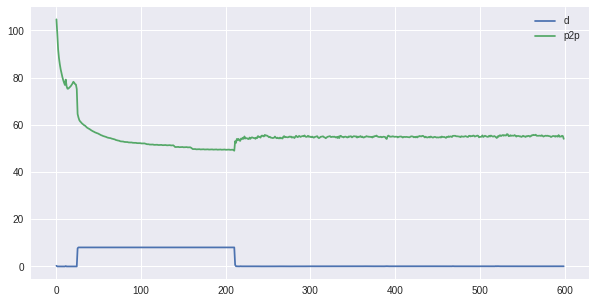

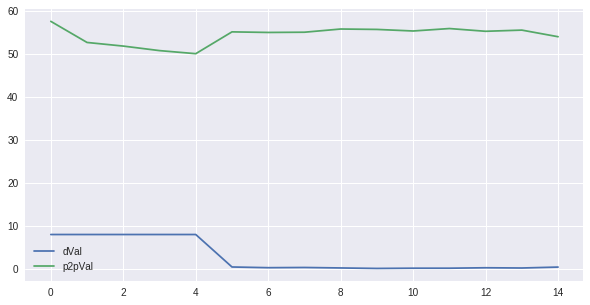

In [54]:
plot_losses(losses)

In [56]:
s1, s2, pan, gen = generateImages(f_gen, valGen, 10)

NN output saved successfully.


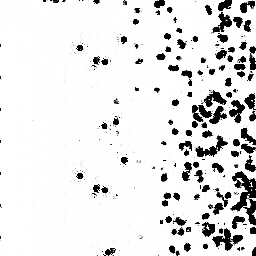

In [27]:
gen[4]

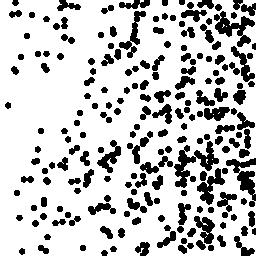

In [28]:
pan[4]